In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
start='2014-01-01'
end='2017-12-31'

In [3]:
tickers = ['AAPL','MSFT','GOOG']
#df = pd.DataFrame()
#for t in tickers:
df = pdr.DataReader(tickers, 'yahoo',start,end)
  
''' NOT NEEDED
  dftemp.reset_index(inplace=True)
  dftemp.set_index('Date', inplace=True)
  
  dftemp.drop(['Volume', 'High','Low','Open','Close'],1,inplace=True)
  df.rename(columns={'Adj Close':t}, inplace=True)
  print(dftemp.head(2))
  if df.empty:
    df = dftemp
  else:
    df = df.join(dftemp, how='outer')
    '''
print(df.head(3))

Attributes       High                         ...  Adj Close                       
Symbols          AAPL        GOOG       MSFT  ...       AAPL        GOOG       MSFT
Date                                          ...                                  
2014-01-02  79.575714  556.788025  37.400002  ...  71.320679  554.481689  32.582050
2014-01-03  79.099998  556.379578  37.220001  ...  69.754066  550.436829  32.362835
2014-01-06  78.114288  557.340942  36.889999  ...  70.134438  556.573853  31.678938

[3 rows x 18 columns]


In [4]:
close = df['Adj Close']
print(close[-2:])

all_weekdays = pd.date_range(start=start, end=end, freq='B')
print(all_weekdays[-2:])

# align existing prices in adj close with new set of dats, reindex close using all weekdays
close = close.reindex(all_weekdays)
print(close[-2:])

#replace missing data, forward fill'
close = close.fillna(method='ffill')

Symbols           AAPL         GOOG       MSFT
Date                                          
2017-12-28  166.553101  1048.140015  83.316124
2017-12-29  164.752060  1046.400024  83.141182
DatetimeIndex(['2017-12-28', '2017-12-29'], dtype='datetime64[ns]', freq='B')
Symbols           AAPL         GOOG       MSFT
2017-12-28  166.553101  1048.140015  83.316124
2017-12-29  164.752060  1046.400024  83.141182


In [5]:
close.describe()

Symbols,AAPL,GOOG,MSFT
count,1042.000000,1042.000000,1042.000000
mean,110.127077,706.346570,50.381351
std,25.127398,153.796575,12.991165
min,64.441742,491.201416,30.670612
25%,92.447876,562.691498,40.343418
50%,106.252281,706.035004,47.973701
75%,120.132206,797.044998,59.582140
max,171.751816,1077.140015,84.414436


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


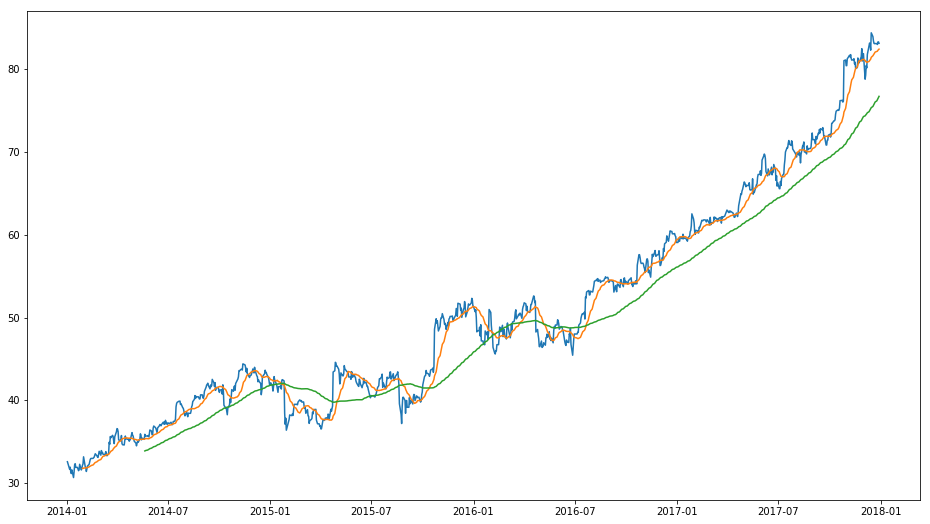

In [6]:
# plot timeseries and rolling means
msft = close.loc[:,'MSFT']

short_mavg = msft.rolling(window=20).mean()
long_mavg = msft.rolling(window=100).mean()

# plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(msft.index, msft, label='msft')
ax.plot(short_mavg.index, short_mavg, label='20ma')
ax.plot(long_mavg.index, long_mavg, label='10ma')


In [7]:
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

# short rolling ma for all
short_rolling = close.rolling(window=20).mean()
# long rolling ma
long_rolling = close.rolling(window=100).mean()
long_rolling.tail()

Symbols,AAPL,GOOG,MSFT
2017-12-25,159.216211,981.519998,76.188473
2017-12-26,159.329992,982.819498,76.318303
2017-12-27,159.434596,984.084198,76.454224
2017-12-28,159.593442,985.493198,76.600439
2017-12-29,159.713324,986.813298,76.734419


In [8]:
# calculate returns and log returns = log (p(t)/p(t-1)) or relative price = p(t)-p(t-1)/p(t-1)
returns = close.pct_change(1)
print(returns.head())
log_returns = np.log(close).diff()
print(log_returns.head())

Symbols         AAPL      GOOG      MSFT
2014-01-01       NaN       NaN       NaN
2014-01-02       NaN       NaN       NaN
2014-01-03 -0.021966 -0.007295 -0.006728
2014-01-06  0.005453  0.011149 -0.021132
2014-01-07 -0.007152  0.019278  0.007750
Symbols         AAPL      GOOG      MSFT
2014-01-01       NaN       NaN       NaN
2014-01-02       NaN       NaN       NaN
2014-01-03 -0.022211 -0.007322 -0.006751
2014-01-06  0.005438  0.011088 -0.021359
2014-01-07 -0.007177  0.019095  0.007720


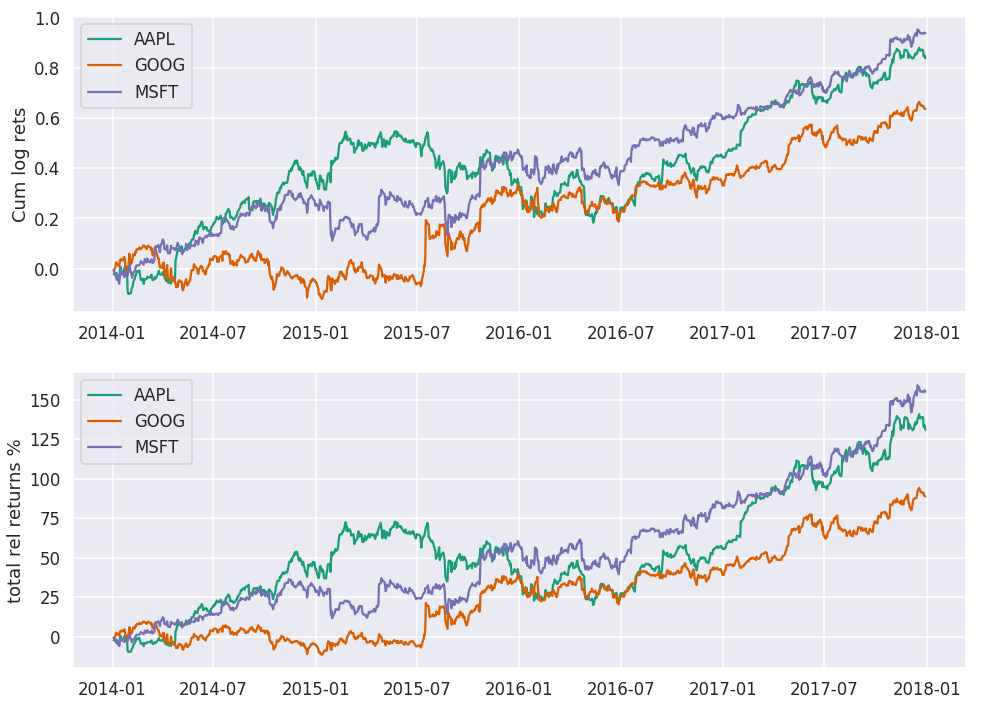

In [9]:
# since log returns are additive, we can create time series of cumulative log-returns
# then convert to relative returns (easier to see value growth) - relative c(t) = e^c(t) -1
# plot cum returns
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,12))
for c in log_returns:
  ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))
ax1.set_ylabel('Cum log rets')
ax1.legend(loc='best')

for c in log_returns:
  ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum())-1), label=str(c))
ax2.set_ylabel("total rel returns %")
ax2.legend(loc='best')
plt.show()

In [10]:
# last day of returns //  make this column vector
r_t = log_returns.tail(1).transpose()
r_t.index

Index(['AAPL', 'GOOG', 'MSFT'], dtype='object', name='Symbols')

In [11]:
# weights for K assets
weights_vector = pd.DataFrame(1/3, index=r_t.index, columns=r_t.columns)
weights_vector

,2017-12-29 00:00:00
Symbols,
AAPL,0.333333
GOOG,0.333333
MSFT,0.333333


In [12]:
# total log return for portfolio
portfolio_log_ret = weights_vector.transpose().dot(r_t)
portfolio_log_ret

,2017-12-29 00:00:00
2017-12-29,-0.004879


In [13]:
# diagonal extraction given 1/3 weights for all stocks w(aapl) = w(msft) = w(goog) == 1/3
weights_matrix = pd.DataFrame(1/3, index=close.index, columns=close.columns)
weights_matrix.tail()


Symbols,AAPL,GOOG,MSFT
2017-12-25,0.333333,0.333333,0.333333
2017-12-26,0.333333,0.333333,0.333333
2017-12-27,0.333333,0.333333,0.333333
2017-12-28,0.333333,0.333333,0.333333
2017-12-29,0.333333,0.333333,0.333333


In [14]:
#Matrix R  is simple log_returns dataframe
log_returns.head()

Symbols,AAPL,GOOG,MSFT
2014-01-01,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN
2014-01-03,-0.022211,-0.007322,-0.006751
2014-01-06,0.005438,0.011088,-0.021359
2014-01-07,-0.007177,0.019095,0.007720


In [15]:
# portfolio returns calculated
temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().iloc[:,0:5]

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00
2014-01-01,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-02,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-03,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-06,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-07,NaN,NaN,-0.012094,-0.001611,0.006546


In [16]:
# now can find the diag np.diag to extract series
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

2017-12-25    0.000000
2017-12-26   -0.010059
2017-12-27   -0.001066
2017-12-28    0.000584
2017-12-29   -0.004879
Freq: B, dtype: float64

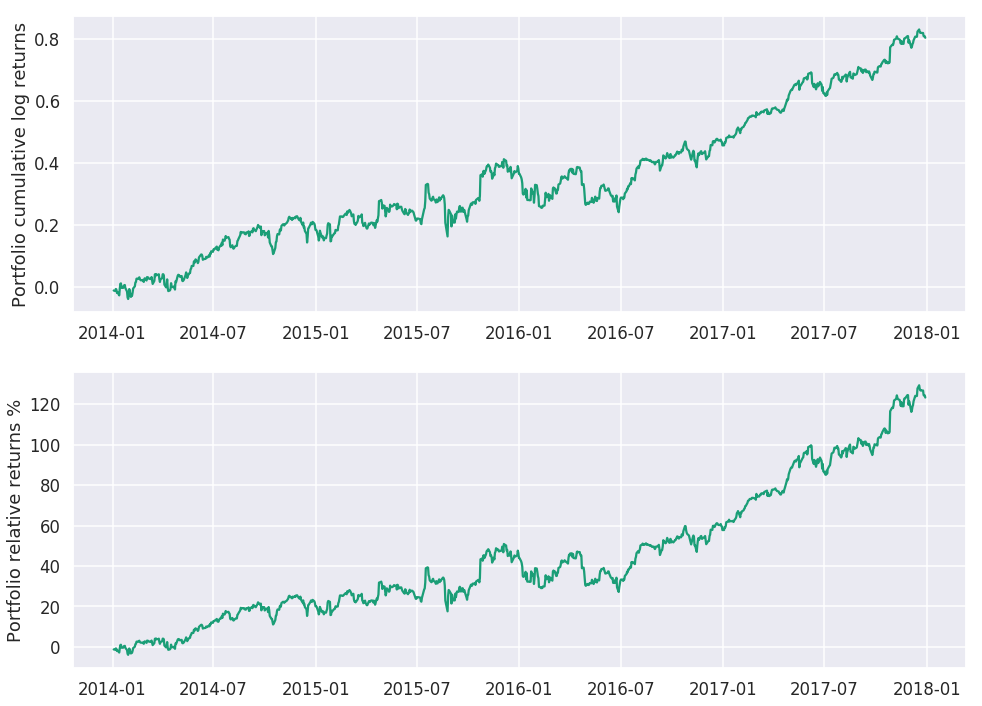

In [17]:
# plot log and rel % returns
total_relative_returns = (np.exp(portfolio_log_returns.cumsum())-1)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100*total_relative_returns)
ax2.set_ylabel('Portfolio relative returns %')
plt.show()

In [18]:
# calculate the yearly return, above have 4 year total return ~120% need to solve for compounding every day
# 1+r^4.2 = 1 + 1.21
days_per_year = 52 * 5
total_days_in_simulation = close.shape[0]
number_of_years = total_days_in_simulation / days_per_year
print('years: ',number_of_years)

total_portfolio_return = total_relative_returns[-1] #this is total cumsum
avg_year_return = (1+ total_portfolio_return)**(1/number_of_years) - 1

print('Total portfolio return : '+ '{:5.2f}'.format(100*total_portfolio_return)+'%')
print('Yearls avg return : '+ '{:5.2f}'.format(100*avg_year_return)+'%')

years:  4.0115384615384615
Total portfolio return : 123.23%
Yearls avg return : 22.16%


In [19]:
import matplotlib.dates as mdates
%matplotlib inline
%autosave 60
my_year_month_fmt = mdates.DateFormatter('%m/%y')

Autosaving every 60 seconds


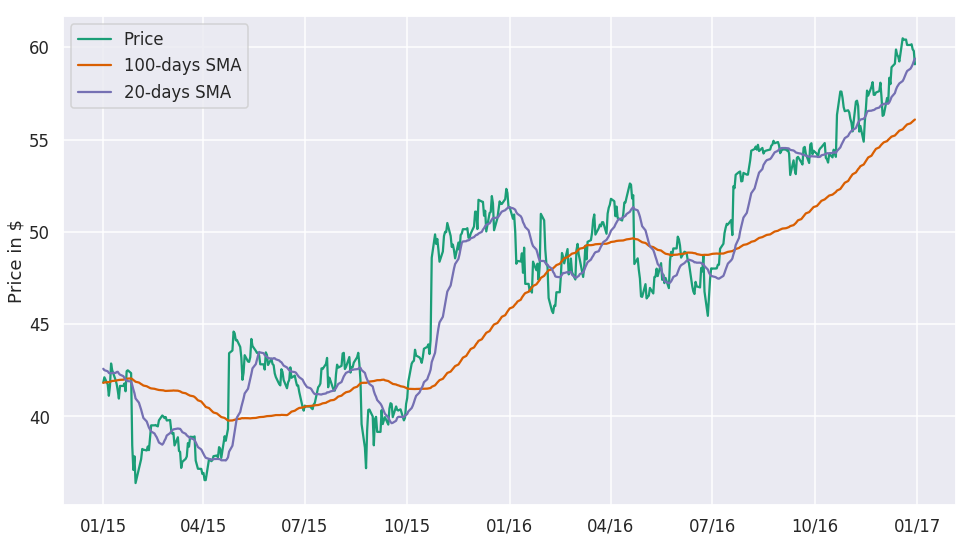

In [20]:
# short_rolling & long_rolling = dataframes with 
# plot rolling avgs
start_date = '2015-01-01'
end_date = '2016-12-31'

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.loc[start_date:end_date, :].index, close.loc[start_date:end_date, 'MSFT'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'MSFT'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'MSFT'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

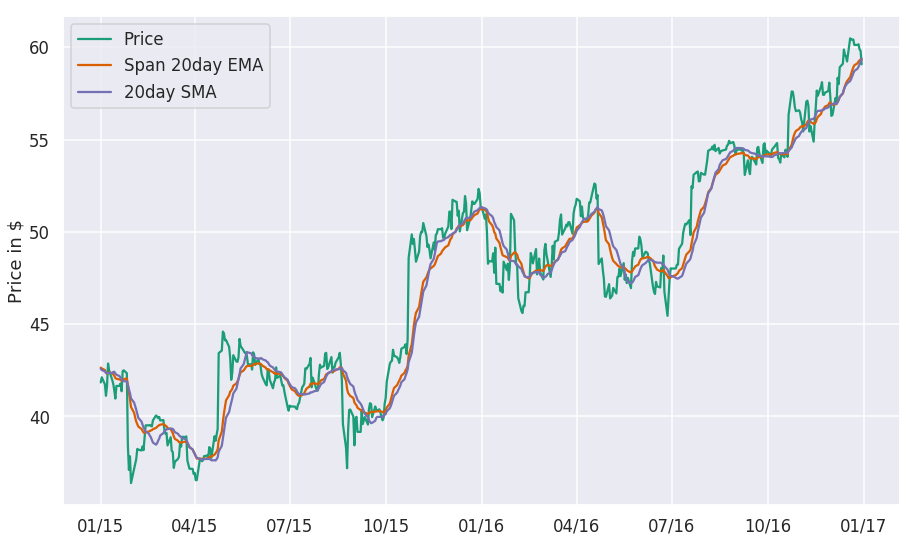

In [21]:
# moving averages much less noise than original price timeseries, SMA lag the original price timeseries, meaning
# the changes in trend are only seen with a delay (lag) of L days
# how much is lag?? -> if MA using 20 days, lag is 20/2 days ((this can affect strategy))
# reduce lag => exponential moving average (EMA) = EMA(t) = 1 - alpha * EMA(t-1) + alpha*p(t)  /// EMA(t0) = p(t0)
# alpha is decay parameter, alpha = 1/L+1 . and length of window = 2/M+1
# EMA puts more weight on recent observations
ema_short = close.ewm(span=20, adjust=False).mean()
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(close.loc[start_date:end_date, :].index, close.loc[start_date:end_date, 'MSFT'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'MSFT'], label='Span 20day EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'MSFT'], label='20day SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [23]:
# take sign of the diff between price p(t) and EMA e(t) for asset i
trading_positions_raw = close - ema_short
trading_positions_raw.tail()

Symbols,AAPL,GOOG,MSFT
2017-12-25,1.997279,12.595128,0.758610
2017-12-26,-2.103794,8.337492,0.589626
2017-12-27,-1.876995,0.875354,0.806083
2017-12-28,-1.275452,-0.320852,0.738100
2017-12-29,-2.783493,-1.864572,0.509524


In [24]:
 # take the sign of the diff to determine whether the price of EMA is greater, then multiply by 1/3 (for each asset i)
  trading_positions = trading_positions_raw.apply(np.sign) * 1/3
  trading_positions.tail()
  # this shows short/long positions for each

Symbols,AAPL,GOOG,MSFT
2017-12-25,0.333333,0.333333,0.333333
2017-12-26,-0.333333,0.333333,0.333333
2017-12-27,-0.333333,0.333333,0.333333
2017-12-28,-0.333333,-0.333333,0.333333
2017-12-29,-0.333333,-0.333333,0.333333


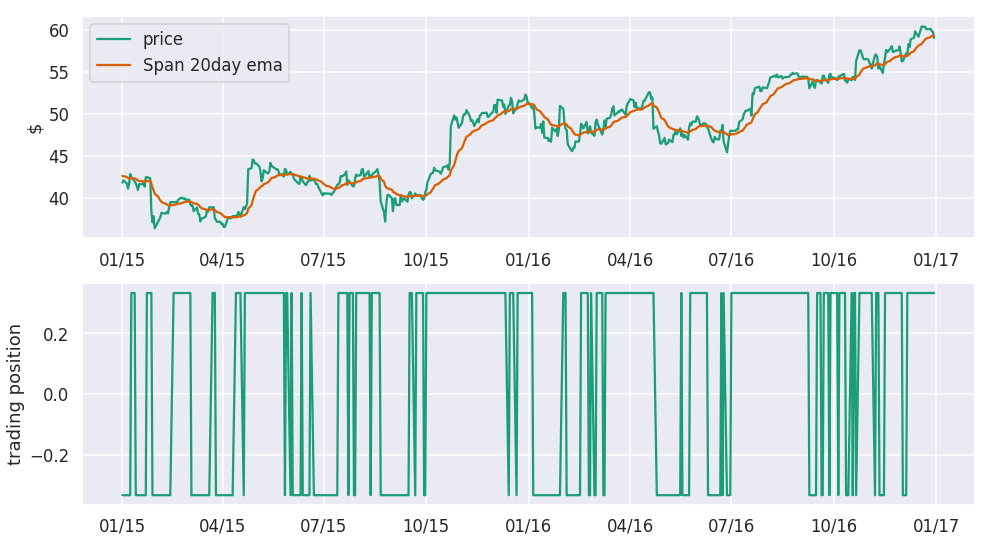

In [27]:
# since close prices are known at end of day, safe to assume we need to lag our trading positions by one day so on day 
# t0 our actual position is that of the previous day t0 - 1 and only t0 +1 do we have a long position
trading_positions_final = trading_positions.shift(1)

#plot to see results
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,9))
ax1.plot(close.loc[start_date:end_date, :].index, close.loc[start_date:end_date, 'MSFT'], label='price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'MSFT'], label='Span 20day ema')
ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date,'MSFT'],label="trading position")
ax2.set_ylabel('trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [28]:
# calculate log returns of each asset
asset_log_returns = np.log(close).diff()
asset_log_returns.head(3)

Symbols,AAPL,GOOG,MSFT
2014-01-01,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN
2014-01-03,-0.022211,-0.007322,-0.006751


In [29]:
# to get the log return for each asset & actual returns = multiply strategy positions with asset log returns
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()


Symbols,AAPL,GOOG,MSFT
2017-12-25,0.000000,0.000000,0.000000
2017-12-26,-0.008566,-0.001064,-0.000429
2017-12-27,-0.000059,-0.002333,0.001208
2017-12-28,-0.000937,-0.000391,0.000039
2017-12-29,0.003624,0.000554,-0.000701


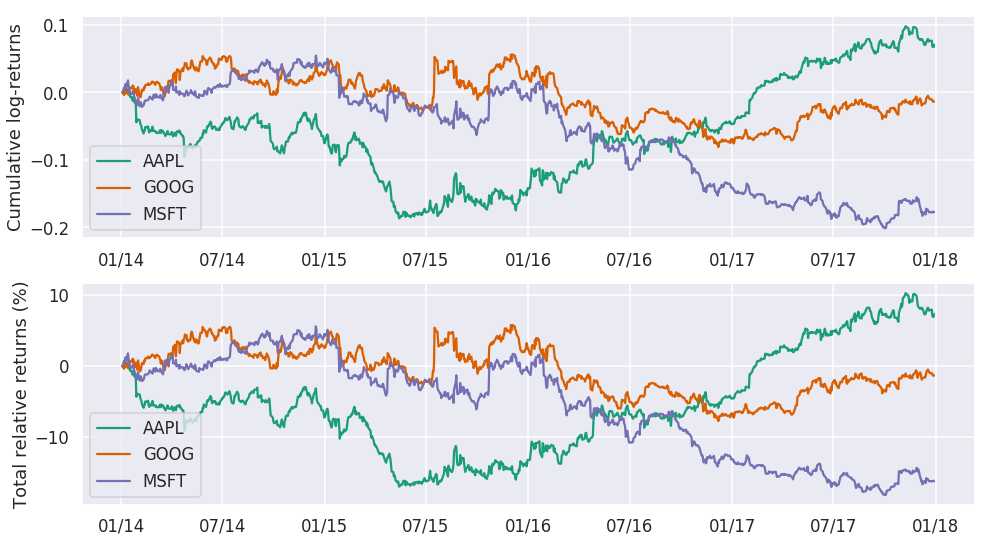

In [30]:
# lets show/plot performance over time, plot cum log returns and cum relative total returns of each strategy
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()
# transform cum log returns to relative
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns)-1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

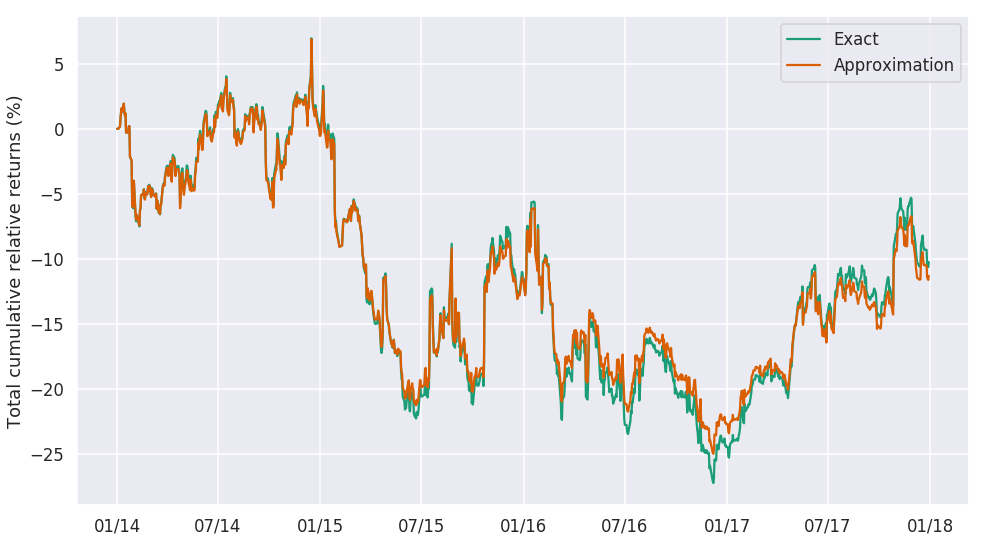

In [31]:
# calculate total return of the strategy, sum from each asset
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1) # exact
# get cum log returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)
# transform cum log returns to relative returns // approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return)-1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [33]:
# care when summing log-returns across time for single asset
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year=52*5):
  total_days_in_sim = portfolio_cumulative_relative_returns.shape[0]
  num_years = total_days_in_sim/days_per_year
  # total portfolio return in last -1 item
  total_portfolio_return = portfolio_cumulative_relative_returns[-1]
  # avg portfolio return compounding of returns
  avg_year_return = (1 + total_portfolio_return)**(1/num_years)-1
  
  print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
  print('Average yearly return is: ' + '{:5.2f}'.format(100*avg_year_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: -10.24%
Average yearly return is: -2.66%


Total portfolio return is: 92.42%
Average yearly return is: 17.72%


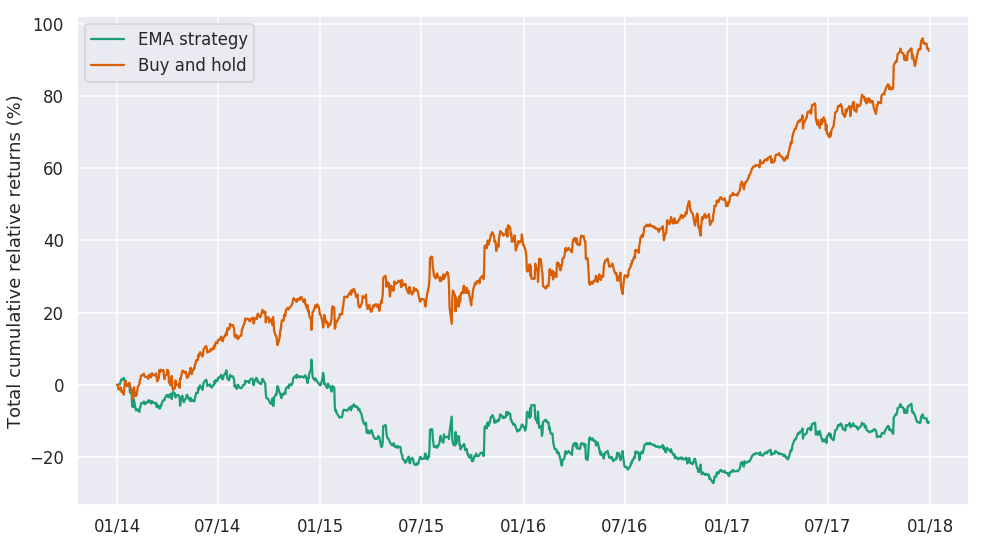

In [35]:
# compare against simple buy and hold strategy

# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = close.index, columns=close.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)